# 1 - RSA Spatial Alignment  

Generate spatial RSA maps for inter‑subject and subject‑model alignment, including boxplots, cortical surface projections, scatter comparisons, and hub‐based contrasts.


## 0. Imports & Setup  
Load required libraries (path handling, data frames, plotting, stats), plus project utilities for power‐law fitting, parcel plotting, figure styling, and alignment processing. Initialize fonts.


In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import seaborn as sns
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# Functions reused in other parts of the project
from convergence.power_law import fit_powerlaw_zero_with_bootstrap
from convergence.plotting import plot_faverage_parcelation, add_area_labels
from convergence.figures import (
    plot_boxplot_rois,
    add_pvalue_bracket,
    plot_cbar,
    plot_comparison,
    setup_matplotlib_fonts,
)
from convergence.figures_utils import add_cluster, process_intersubject_rois, proccess_alignment

setup_matplotlib_fonts()

## 1. Data Paths & Validation  
Define paths to derivatives folder, metadata (HCP atlas, model info), RSA p‑value tables, and alignment parquet files. Create output directory and assert that all required inputs exist.


In [2]:
# Required filenames for the figures
data_folder = Path("../derivatives")
hcp_filename = data_folder / "metadata" / "hcp.csv"
models_filename = data_folder / "metadata" / "models-info.csv"
nsd_folder = data_folder / "nsd"
pvalues_filename = nsd_folder / "rsa_pvalues_subject_language_vision.parquet"
intersubject_shift1_joined_filename = nsd_folder / "rsa_subject_subject_alignment_shift_1_joined.parquet"
intersubject_shift1_separated_filename = nsd_folder / "rsa_subject_subject_alignment_shift_1_separated.parquet"
model_brain_joined_filename = nsd_folder / "rsa_subject_model_alignment_joined.parquet"
model_brain_separated_filename = nsd_folder / "rsa_subject_model_alignment_separated.parquet"

# Output folder for figures
figure_folder = Path("../figures")
output = figure_folder / "01_rsa_spatial_alignment"
output.mkdir(exist_ok=True, parents=True)


## 2. ROI RSA Boxplots  
Visualize ROI‑wise RSA distributions with null distributions and statistical annotations.


### 2.1 Inter‑subject — Top Areas  
– Select the top 10 anatomical areas by mean alignment.  
– Overlay group‑level null mean ± std.  
– Draw per‑ROI boxplots of inter‑subject RSA and annotate paired t‑test p‑value brackets.


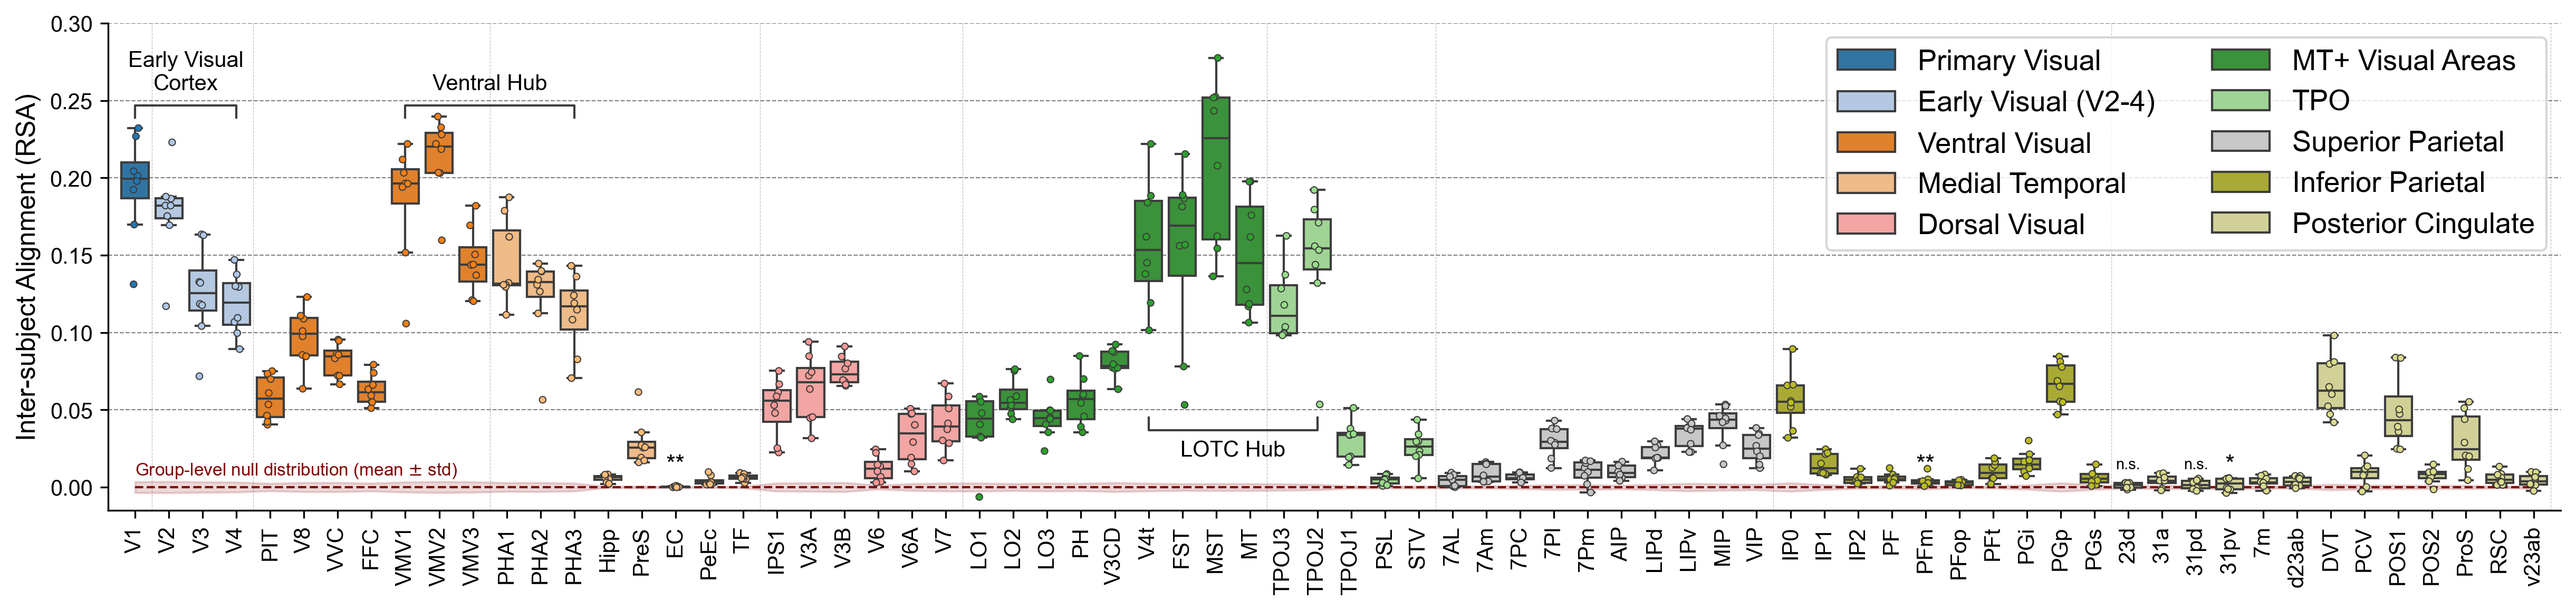

In [3]:
# Load the inter-subject alignment data
df = pd.read_parquet(intersubject_shift1_joined_filename)

# Process the data to get the top 10 ROIs (aggregate and filter) and select rois of top areas
df_g = process_intersubject_rois(df, hcp_filename=hcp_filename, top=10)
order = (
    df_g.sort_values(["area_id", "roi_order"])
    .drop_duplicates("roi")
    .drop_duplicates("name")
    .name.tolist()
)
order_roi = df_g.sort_values(["area_id", "roi_order"]).drop_duplicates("roi").roi.tolist()
hue_order = df_g.sort_values("area_id").drop_duplicates("area_id").area.tolist()
palette = df_g.sort_values("area_id").drop_duplicates("area_id").area_color.tolist()


# Sort by order
df_subject_pvalues = pd.read_parquet(pvalues_filename).query("comparison == 'intersubject'")
df_subject_pvalues.name = df_subject_pvalues.name.replace("H", "Hipp")
df_subject_pvalues = df_subject_pvalues.set_index("roi")
df_subject_pvalues = df_subject_pvalues.loc[order_roi].reset_index()

# The df_subject_pvalues is sorted in the same order that boxplots.
# Plot the mean line given by null_mean column of df_subject_pvalues
null_std = df_subject_pvalues.null_std.values
null_mean = df_subject_pvalues.null_mean.values

fig, ax = plt.subplots(1, 1, figsize=(20, 4), dpi=300)

ax.fill_between(
    np.arange(len(order)), null_mean - null_std, null_mean + null_std, color="maroon", alpha=0.15
)
ax.plot(
    np.arange(len(order)),
    df_subject_pvalues.null_mean.values,
    color="maroon",
    linestyle="--",
    linewidth=1,
)

plot_boxplot_rois(
    df_g,
    ax,
    order,
    hue_order,
    palette,
    title="",
    legend=True,
    fontsize=10,
    legend_fontsize=13,
    legend_kwargs={"bbox_to_anchor": (1, 1), "title": ""},
    vmax=0.3,
)
ax.set_ylabel(r"Inter-subject Alignment (RSA)", fontsize=12)

add_pvalue_bracket(
    ax=ax,
    x1=0,
    x2=3,
    y=0.25 - 0.011,
    y_text=0.268 - 0.011,
    height=0.008,
    text="Early Visual\nCortex",
)
add_pvalue_bracket(
    ax=ax, x1=8, x2=13, y=0.25 - 0.011, y_text=0.268 - 0.011, height=0.008, text="Ventral Hub"
)
add_pvalue_bracket(ax=ax, x1=30, x2=35, y=0.045, y_text=0.02, height=-0.008, text="LOTC Hub")


# Set yaxis (RSA) in decimal format not percentage
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
ax.set_ylim(-0.015, 0.30)
ax.set_xlim(-0.8, 71.8)
ax.text(
    0,
    0.008,
    r"Group-level null distribution (mean $\pm$ std)",
    color="maroon",
    fontsize=8,
    ha="left",
)

# Add p-values
apa_significance = df_subject_pvalues.apa_star.values
for i, (p, name) in enumerate(zip(apa_significance, order)):
    if p != "***":
        if p == "n.s.":
            ax.text(i, 0.012, p, fontsize=7, ha="center")
        else:
            ax.text(i, 0.01, p, fontsize=11, ha="center")

fig.savefig(
    output / "01_rsa_intersubject_boxplot_selected_shift_1.pdf",
    bbox_inches="tight",
    transparent=True,
)

### 2.2 Inter‑subject — All Areas  
– Repeat full‑brain boxplot for every ROI.  
– Adjust strip sizes and fonts for high‑density plotting.  
– Annotate key area comparisons.

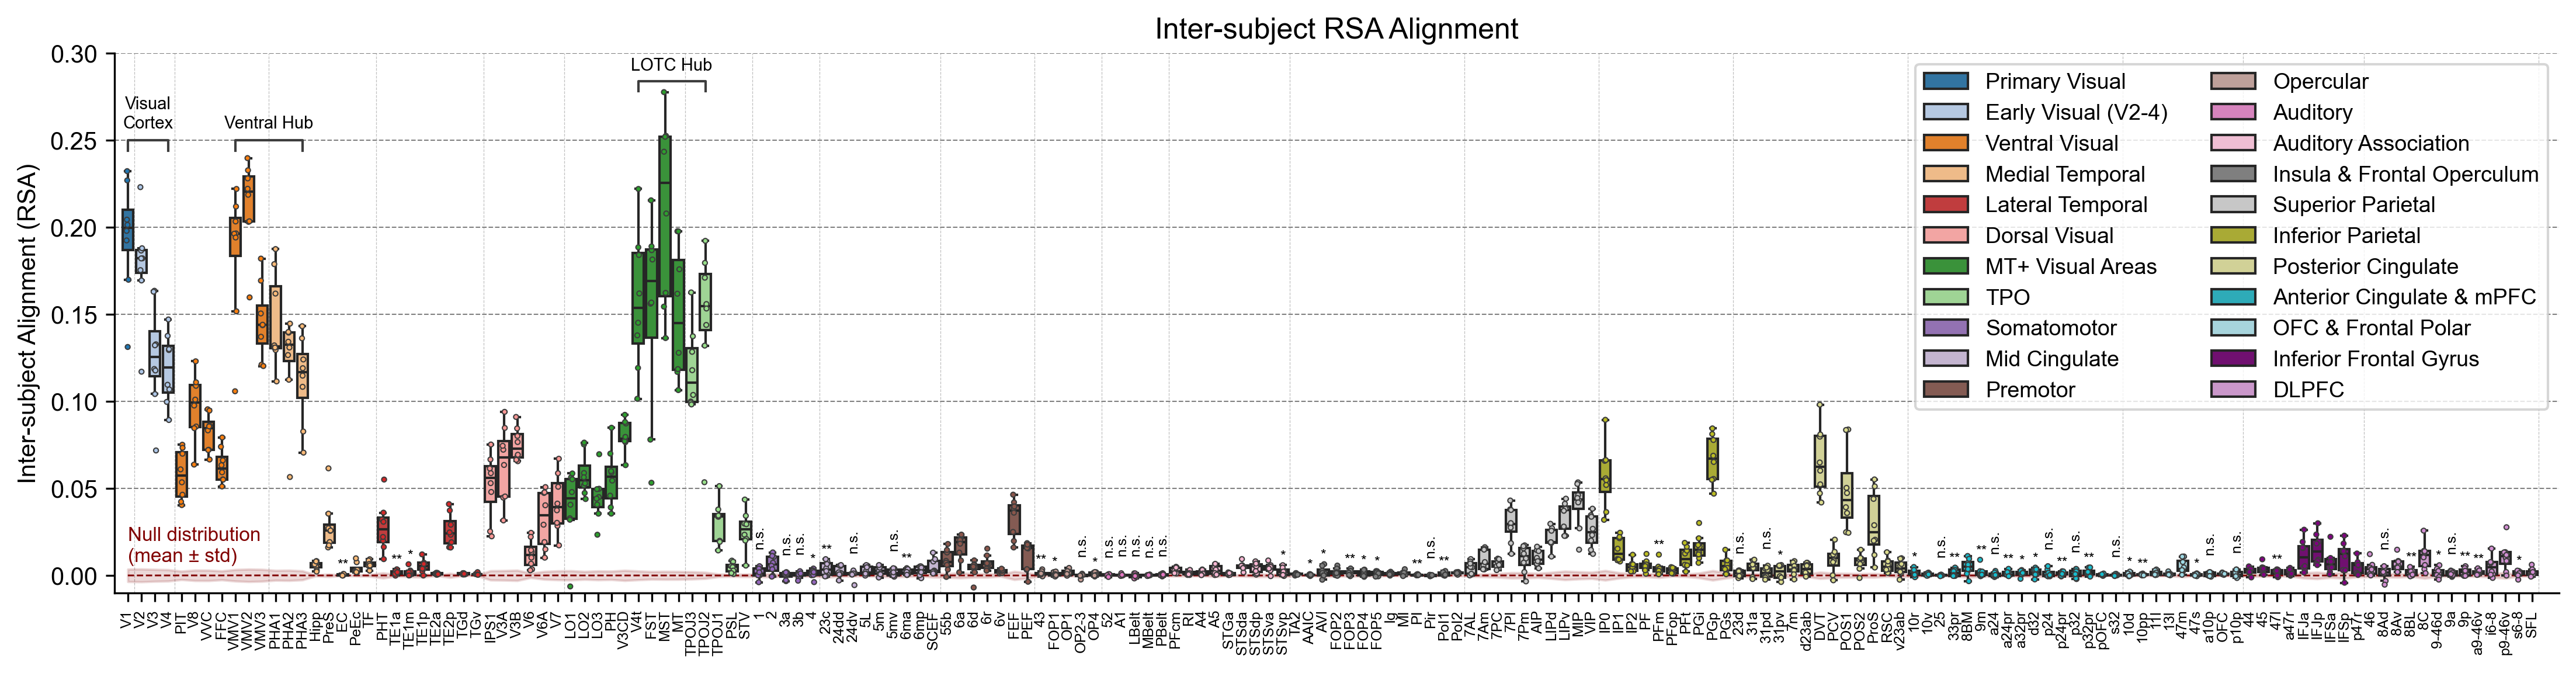

In [4]:
df = pd.read_parquet(intersubject_shift1_joined_filename)
df_g = process_intersubject_rois(
    df, hcp_filename=hcp_filename, top=1000
)  # If select more than max rois it will take all
order = df_g.sort_values(["area_id", "roi_order"]).drop_duplicates("name").name.unique()
order_roi = df_g.sort_values(["area_id", "roi_order"]).drop_duplicates("roi").roi.unique()
hue_order = list(df_g.sort_values("area_id").drop_duplicates("area_id").area.tolist())
palette = list(df_g.sort_values("area_id").drop_duplicates("area_id").area_color.tolist())
models_info = pd.read_csv(models_filename)

# Sort by order
df_subject_pvalues = pd.read_parquet(pvalues_filename).query("comparison == 'intersubject'")
df_subject_pvalues.name = df_subject_pvalues.name.replace("H", "Hipp")
df_subject_pvalues = df_subject_pvalues.set_index("roi")
#
df_subject_pvalues = df_subject_pvalues.loc[order_roi].reset_index()


fig, ax = plt.subplots(1, 1, figsize=(18, 4), dpi=300)

null_mean = df_subject_pvalues.null_mean.values
null_std = df_subject_pvalues.null_std.values

ax.fill_between(
    np.arange(len(order)), null_mean - null_std, null_mean + null_std, color="maroon", alpha=0.15
)
ax.plot(
    np.arange(len(order)),
    df_subject_pvalues.null_mean.values,
    color="maroon",
    linestyle="--",
    linewidth=0.7,
)

plot_boxplot_rois(
    df_g,
    ax,
    order,
    hue_order,
    palette,
    title="",
    legend=True,
    fontsize=6,
    legend_fontsize=9,
    legend_kwargs={"bbox_to_anchor": (1, 1), "title": ""},
    vmax=0.3,
    strip_size=2,
)
ax.set_ylabel("Inter-subject Alignment (RSA)")
ax.text(0, 0.008, "Null distribution\n(mean ± std)", color="maroon", fontsize=8, ha="left")

# Set yaxis (RSA) in decimal format not percentage
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
ax.set_title("Inter-subject RSA Alignment")

apa_significance = df_subject_pvalues.apa_star.values
max_observed_values = df_g.groupby("name").aggregate({"score": "max"}).loc[order].score.values

for i, (p, name, max_observed) in enumerate(zip(apa_significance, order, max_observed_values)):
    if p != "***":
        if p == "n.s.":
            ax.text(i, max_observed + 0.01, p, fontsize=6, ha="center", rotation=90, va="bottom")
        else:
            ax.text(i, max_observed + 0.005, p, fontsize=6, ha="center", rotation=0, va="center")


add_pvalue_bracket(
    ax=ax,
    x1=0,
    x2=3,
    y=0.25 - 0.006,
    y_text=0.268 - 0.011,
    height=0.006,
    text="Visual\nCortex",
    fontsize=7,
)
add_pvalue_bracket(
    ax=ax,
    x1=8,
    x2=13,
    y=0.25 - 0.006,
    y_text=0.268 - 0.011,
    height=0.006,
    text="Ventral Hub",
    fontsize=7,
)
add_pvalue_bracket(
    ax=ax,
    x1=38,
    x2=43,
    y=0.29 - 0.006 - 0.006,
    y_text=0.29 - 0.011 + 0.018 - 0.007,
    height=0.006,
    text="LOTC Hub",
    fontsize=7,
)


fig.savefig(
    output / "01_rsa_intersubject_boxplot_all_shift_1.pdf", bbox_inches="tight", transparent=True
)

### 2.3 Subject‑Model — Vision Models  
– Compute per‑ROI vision model vs. brain RSA.  
– Overlay group null, plot boxplots, annotate p‑values, and save with/without legend.

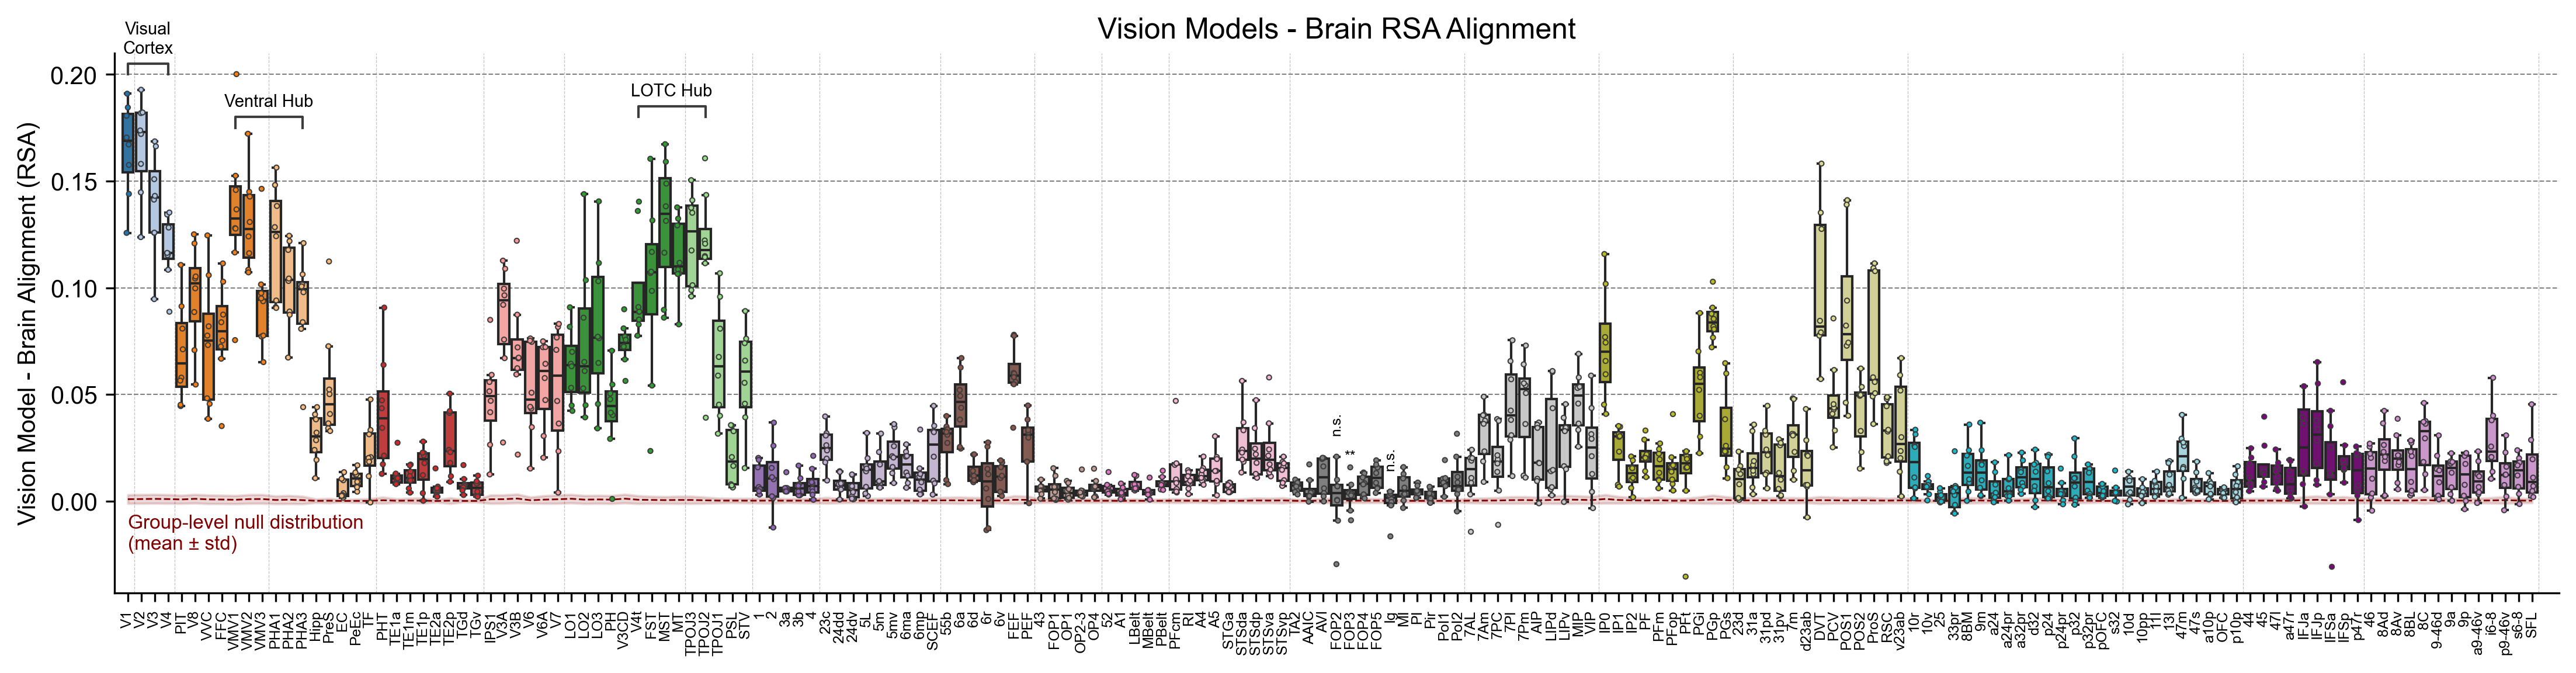

In [5]:
# Load models info
models_info = pd.read_csv(models_filename)

df_comparison_subjects = proccess_alignment(
    models_filename=models_filename,
    models_alignment_filename=model_brain_joined_filename,
    subject_alignment_filename=intersubject_shift1_joined_filename,
    pvalues_filename=pvalues_filename,
    hcp_filename=hcp_filename,
    group_subject=False,
)
df_comparison_subjects.name = df_comparison_subjects.name.replace("H", "Hipp")
df_comparison_subjects = df_comparison_subjects.sort_values(["area_id", "roi_order"]).reset_index(
    drop=True
)
order = (
    df_comparison_subjects.sort_values(["area_id", "roi_order"])
    .drop_duplicates("name")
    .name.unique()
)
order_roi = (
    df_comparison_subjects.sort_values(["area_id", "roi_order"]).drop_duplicates("roi").roi.unique()
)
hue_order = list(
    df_comparison_subjects.sort_values("area_id").drop_duplicates("area_id").area.tolist()
)
palette = list(
    df_comparison_subjects.sort_values("area_id").drop_duplicates("area_id").area_color.tolist()
)


null_mean = df_comparison_subjects.drop_duplicates("roi").vision_null_mean.values
null_std = df_comparison_subjects.drop_duplicates("roi").vision_null_std.values

# Make the plot
fig, ax = plt.subplots(1, 1, figsize=(18, 4), dpi=300)
ax.fill_between(
    np.arange(len(order)), null_mean - null_std, null_mean + null_std, color="maroon", alpha=0.15
)
ax.plot(np.arange(len(order)), null_mean, color="maroon", linestyle="--", linewidth=0.7)
plot_boxplot_rois(
    df_comparison_subjects.rename(columns={"vision_rsa": "score"}),
    ax,
    order,
    hue_order,
    palette,
    title="",
    legend=True,
    fontsize=6,
    legend_fontsize=9,
    legend_kwargs={"bbox_to_anchor": (1, 1), "title": ""},
    vmax=0.23,
    strip_size=2,
)
ax.set_ylabel("Vision Model - Brain Alignment (RSA)")
ax.text(
    0,
    -0.006,
    "Group-level null distribution\n(mean ± std)",
    color="maroon",
    fontsize=8,
    ha="left",
    va="top",
)

# Plot the significance of the p-values
apa_significance = df_comparison_subjects.drop_duplicates("roi").vision_apa_star
max_observed_values = (
    df_comparison_subjects.groupby("name")
    .aggregate({"vision_rsa": "max"})
    .loc[order]
    .vision_rsa.values
)

for i, (p, name, max_observed) in enumerate(zip(apa_significance, order, max_observed_values)):
    if p != "***":
        # print(p, name, max_observed)
        if p == "n.s.":
            ax.text(i, max_observed + 0.01, p, fontsize=6, ha="center", rotation=90, va="bottom")
        else:
            ax.text(i, max_observed + 0.005, p, fontsize=6, ha="center", rotation=0, va="center")


add_pvalue_bracket(
    ax=ax, x1=0, x2=3, y=0.20, y_text=0.21, height=0.005, text="Visual\nCortex", fontsize=7
)
add_pvalue_bracket(
    ax=ax, x1=8, x2=13, y=0.175, y_text=0.185, height=0.005, text="Ventral Hub", fontsize=7
)
add_pvalue_bracket(
    ax=ax, x1=38, x2=43, y=0.18, y_text=0.19, height=0.005, text="LOTC Hub", fontsize=7
)

ax.set_title("Vision Models - Brain RSA Alignment")

ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
ax.set_ylim(-0.043, 0.21)

# Save with legend
fig.savefig(output / "02_rsa_vision_boxplot_all.pdf", bbox_inches="tight", transparent=True)

# Save without legend
ax.get_legend().remove()
fig.savefig(
    output / "03_rsa_vision_boxplot_all_no_legend.pdf", bbox_inches="tight", transparent=True
)


### 2.4 Subject‑Model — Language Models  
– Same as 2.3 but for language models, with separate null overlay and significance brackets.


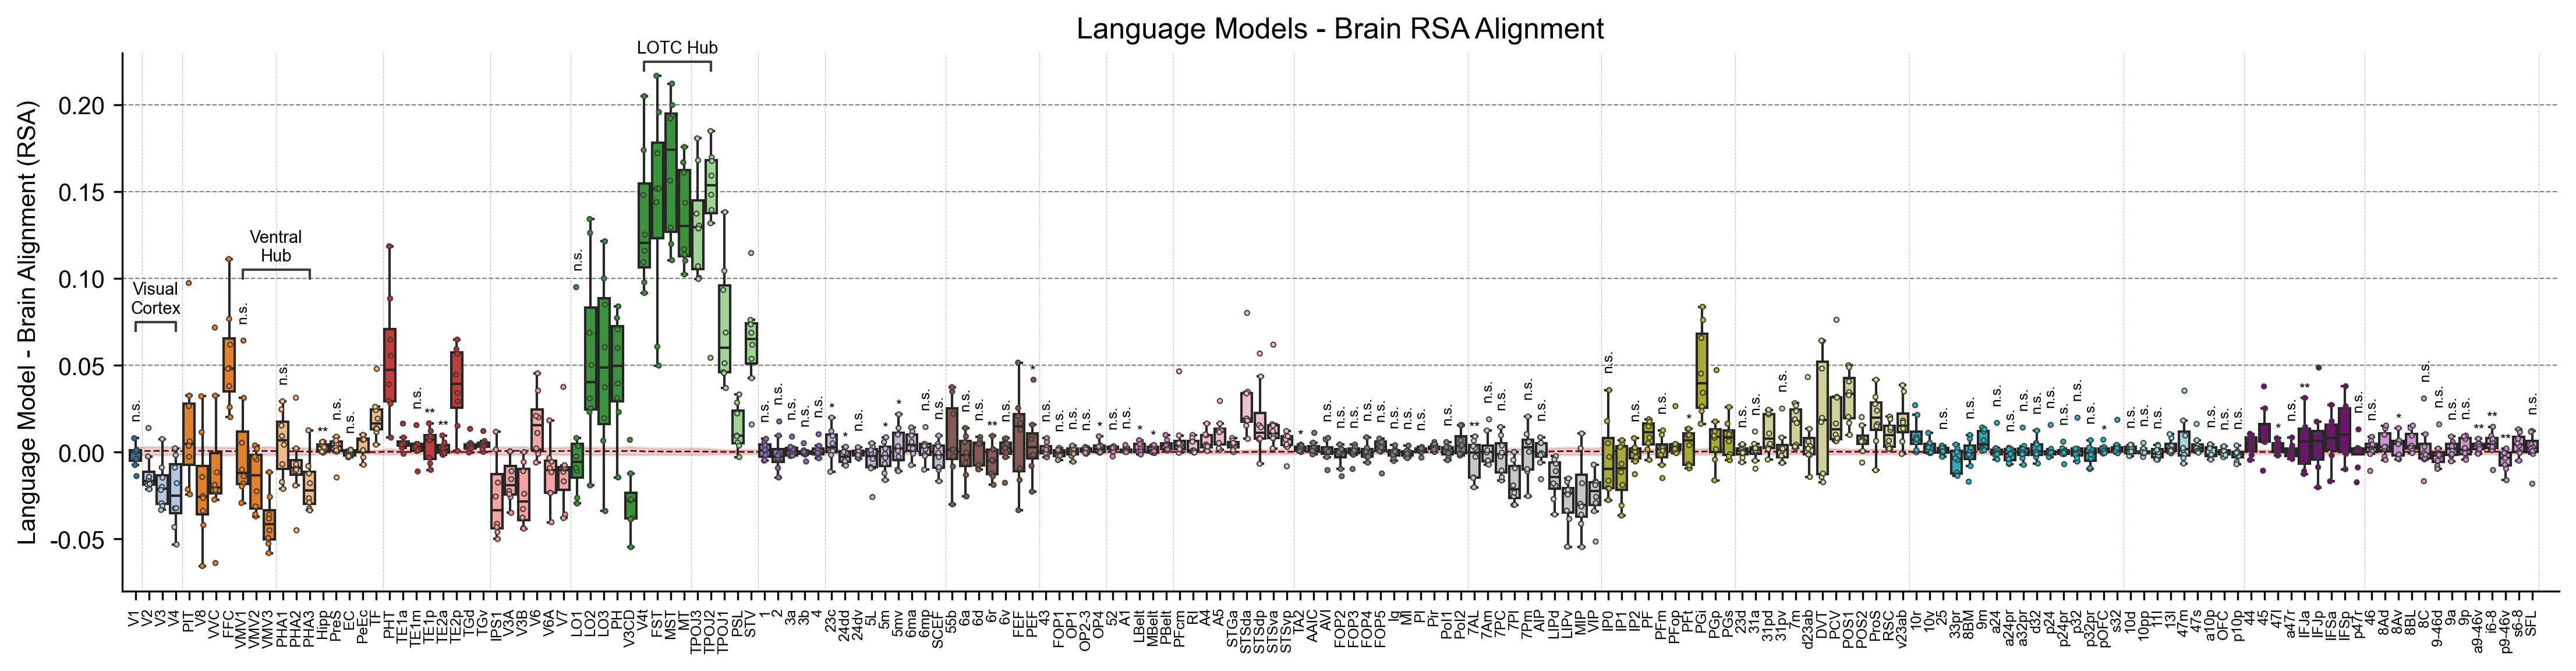

In [6]:
models_info = pd.read_csv(models_filename)

df_comparison_subjects = proccess_alignment(
    models_filename=models_filename,
    models_alignment_filename=model_brain_joined_filename,
    subject_alignment_filename=intersubject_shift1_joined_filename,
    pvalues_filename=pvalues_filename,
    hcp_filename=hcp_filename,
    group_subject=False,
)
df_comparison_subjects.name = df_comparison_subjects.name.replace("H", "Hipp")
df_comparison_subjects = df_comparison_subjects.sort_values(["area_id", "roi_order"]).reset_index(
    drop=True
)
order = (
    df_comparison_subjects.sort_values(["area_id", "roi_order"])
    .drop_duplicates("name")
    .name.unique()
)
order_roi = (
    df_comparison_subjects.sort_values(["area_id", "roi_order"]).drop_duplicates("roi").roi.unique()
)
hue_order = list(
    df_comparison_subjects.sort_values("area_id").drop_duplicates("area_id").area.tolist()
)
palette = list(
    df_comparison_subjects.sort_values("area_id").drop_duplicates("area_id").area_color.tolist()
)
null_mean = df_comparison_subjects.drop_duplicates("roi").language_null_mean.values
null_std = df_comparison_subjects.drop_duplicates("roi").language_null_std.values


fig, ax = plt.subplots(1, 1, figsize=(18, 4), dpi=300)
ax.fill_between(
    np.arange(len(order)), null_mean - null_std, null_mean + null_std, color="maroon", alpha=0.15
)
ax.plot(np.arange(len(order)), null_mean, color="maroon", linestyle="--", linewidth=0.7)

plot_boxplot_rois(
    df_comparison_subjects.rename(columns={"language_rsa": "score"}),
    ax,
    order,
    hue_order,
    palette,
    title="",
    legend=True,
    fontsize=6,
    legend_fontsize=9,
    legend_kwargs={"bbox_to_anchor": (1, 1), "title": ""},
    vmax=0.23,
    strip_size=2,
)
ax.set_ylabel("Language Model - Brain Alignment (RSA)")
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))


apa_significance = df_comparison_subjects.drop_duplicates("roi").language_apa_star
max_observed_values = (
    df_comparison_subjects.groupby("name")
    .aggregate({"language_rsa": "max"})
    .loc[order]
    .language_rsa.values
)

for i, (p, name, max_observed) in enumerate(zip(apa_significance, order, max_observed_values)):
    if p != "***":
        if p == "n.s.":
            ax.text(i, max_observed + 0.01, p, fontsize=6, ha="center", rotation=90, va="bottom")
        else:
            ax.text(i, max_observed + 0.005, p, fontsize=6, ha="center", rotation=0, va="center")


add_pvalue_bracket(
    ax=ax, x1=0, x2=3, y=0.07, y_text=0.08, height=0.005, text="Visual\nCortex", fontsize=7
)
add_pvalue_bracket(
    ax=ax, x1=8, x2=13, y=0.1, y_text=0.11, height=0.005, text="Ventral\nHub", fontsize=7
)
add_pvalue_bracket(
    ax=ax, x1=38, x2=43, y=0.22, y_text=0.23, height=0.005, text="LOTC Hub", fontsize=7
)

ax.set_ylim(-0.08, 0.23)

ax.set_title("Language Models - Brain RSA Alignment")
fig.savefig(
    output / "04_rsa_language_boxplot_all.pdf", bbox_inches="tight", dpi=300, transparent=True
)

# Save without legend
ax.get_legend().remove()
fig.savefig(
    output / "05_rsa_language_boxplot_all_no_legend.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

## 3. Group Average Cortical Maps  
Project group‑mean RSA values onto the fsaverage surface for three modalities: inter‑subject, vision, and language.


### 3.1 Surface Plotting  
For each modality and hemisphere (lh/rh), render lateral, medial, ventral, and caudal views; save PNG/TIFF with and without area labels.


In [7]:
visual_cortex = ["V1", "V2", "V3", "V4"]
ventral_cluster = ["VMV1", "VMV2", "VMV3", "PHA1", "PHA2", "PHA3"]
dorsal_cluster = ["MT", "MST", "FST", "V4t", "TPOJ2", "TPOJ3"]
visual_cortex_color = "gray"
ventral_cluster_color = "#3d3d3d"
dorsal_cluster_color = "#2ca02c"

# Load all the files and aggregate the data
df_comparison_subjects = proccess_alignment(
    models_filename=models_filename,
    models_alignment_filename=model_brain_separated_filename,
    subject_alignment_filename=intersubject_shift1_separated_filename,
    pvalues_filename=pvalues_filename,
    hcp_filename=hcp_filename,
    group_subject=True,
)

# Load HCP and annotate hubs to add the areas in the map
hcp_annotated = pd.read_csv(hcp_filename)
hcp_annotated.loc[hcp_annotated.name.isin(ventral_cluster), "area_id"] = -1
hcp_annotated.loc[hcp_annotated.name.isin(ventral_cluster), "area_color"] = ventral_cluster_color
hcp_annotated.loc[hcp_annotated.name.isin(dorsal_cluster), "area_id"] = -2
hcp_annotated.loc[hcp_annotated.name.isin(dorsal_cluster), "area_color"] = dorsal_cluster_color
hcp_annotated.loc[hcp_annotated.name.isin(visual_cortex), "area_id"] = -3

df = df_comparison_subjects.drop(columns=["name", "mne_name"]).merge(
    hcp_annotated[["roi", "name", "mne_name"]], on="roi"
)


modalities = {
    "language": {"column": "language_rsa", "pvalue_column": "language_p_value", "vmax": 0.15},
    "vision": {"column": "vision_rsa", "pvalue_column": "vision_p_value", "vmax": 0.15},
    "intersubject": {
        "column": "intersubject_rsa",
        "pvalue_column": "intersubject_p_value",
        "vmax": 0.2,
    },
}

faverage_folder = output / "06_faverage_spatial"
faverage_folder.mkdir(exist_ok=True, parents=True)

for modality in modalities.keys():
    params = modalities[modality]
    pvalue_column = params["pvalue_column"]
    vmax = params["vmax"]
    print(f"Processing modality: {modality} scale: ({-vmax}, 0, {vmax})")

    column = params["column"]
    significant = df_comparison_subjects.query(f"{pvalue_column} < 0.05").name.tolist()
    df_modality = df.query(f"name in @significant")
    for hemisphere in ["lh", "rh"]:
        brain = plot_faverage_parcelation(
            df_modality,
            cmap="RdBu_r",
            value_column=column,
            normalize=(-vmax, vmax),
            default_value=None,
            default_color="lightgray",
            hemisphere=hemisphere,
            size=(2 * 800, 2 * 600),
        )
        for view in ["lateral", "medial", "ventral", "caudal"]:
            brain.show_view(view)
            brain.save_image(
                faverage_folder / f"06_rsa_{modality}_{hemisphere}_{view}_{vmax:.2f}.png",
                mode="rgba",
            )
            # Save also as tigg
            brain.save_image(
                faverage_folder / f"06_rsa_{modality}_{hemisphere}_{view}_{vmax:.2f}.tiff",
                mode="rgba",
            )

        add_area_labels(brain, hcp_annotated, area_ids=[-1, -2, -3], hemispheres=[hemisphere])

        for view in ["lateral", "medial", "ventral", "caudal"]:
            brain.show_view(view)
            brain.save_image(
                faverage_folder / f"06_rsa_{modality}_{hemisphere}_{view}_{vmax:.2f}_annot.png",
                mode="rgba",
            )
            brain.save_image(
                faverage_folder / f"06_rsa_{modality}_{hemisphere}_{view}_{vmax:.2f}_annot.tiff",
                mode="rgba",
            )

        brain.close()

Processing modality: language scale: (-0.15, 0, 0.15)
Processing modality: vision scale: (-0.15, 0, 0.15)
Processing modality: intersubject scale: (-0.2, 0, 0.2)


Inspect generated brain surface maps

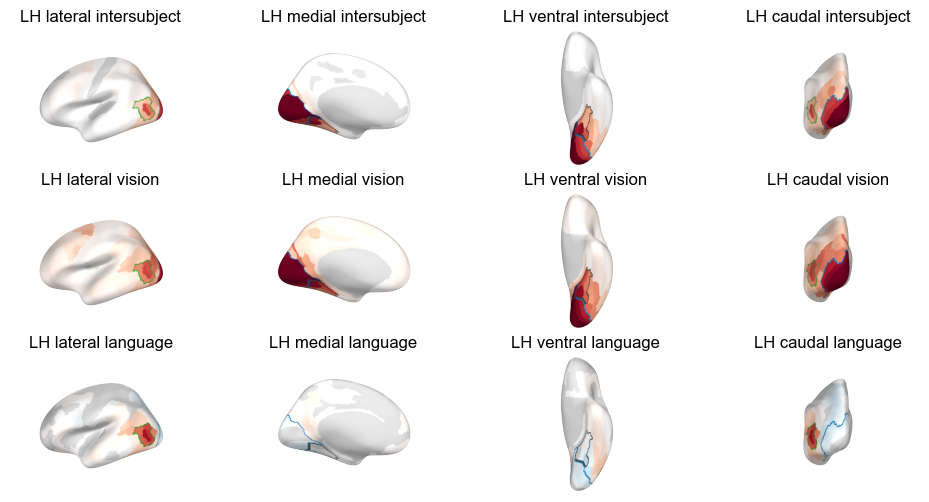

In [8]:
hemisphere = "lh" # "lh", "rh"
views = ["lateral", "medial", "ventral", "caudal"]

fig, axes = plt.subplots(3, len(views), figsize=(12, 6))

for j, modality in enumerate(["intersubject", "vision", "language"]):
    for i, view in enumerate(views):
        vmax_file = modalities[modality]["vmax"]
        img_filename = faverage_folder / f"06_rsa_{modality}_{hemisphere}_{view}_{vmax_file:.2f}_annot.png"
        img = plt.imread(img_filename)
        axes[j, i].axis("off")
        axes[j, i].imshow(img)
        axes[j, i].set_title(f"{hemisphere.upper()} {view} {modality}", fontsize=12)

### 3.2 Colorbars  
Generate horizontal and vertical colorbars for RSA scales (−vmax…+vmax) to accompany spatial maps.


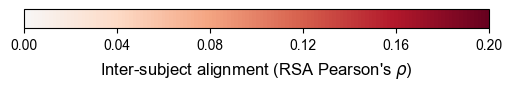

In [9]:
eps = 0.00000001
vmax = 0.20
fig_cbar, ax_cbar = plot_cbar(
    cmap="RdBu_r",
    title=r"Inter-subject alignment (RSA Pearson's $\rho$)",
    vmin=-vmax - eps,
    vmax=vmax + eps,
    locator=0.04,
    horizontal=True,
    rotation=0,
    labelpad=5,
    figsize=(6, 0.25),
    percent=False,
)
ax_cbar.set_xlim(0, vmax + eps)

fig_cbar.savefig(
    faverage_folder / f"06_colorbar_intersubject_{vmax:.2f}_BuRd.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

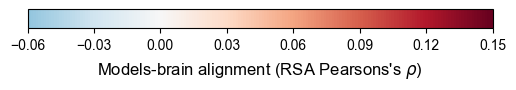

In [10]:
vmax = 0.15
fig_cbar, ax_cbar = plot_cbar(
    cmap="RdBu_r",
    title=r"Models-brain alignment (RSA Pearsons's $\rho$)",
    vmin=-vmax - eps,
    vmax=vmax + eps,
    locator=0.03,
    horizontal=True,
    rotation=0,
    labelpad=5,
    figsize=(6, 0.25),
    percent=False,
)
ax_cbar.set_xlim(-0.06, vmax)
fig_cbar.savefig(
    faverage_folder / f"06_colorbar_model_{vmax:.2f}_BuRd.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)


fig_cbar, ax_cbar = plot_cbar(
    cmap="RdBu_r",
    title=r"Models-brain alignment (RSA)",
    vmin=-vmax - eps,
    vmax=vmax + eps,
    locator=0.03,
    horizontal=False,
    rotation=90,
    labelpad=5,
    figsize=(0.25, 6),
    percent=False,
)
ax_cbar.set_ylim(-0.06, vmax)
fig_cbar.savefig(
    faverage_folder / f"06_colorbar_model_{vmax:.2f}_BuRd_horizontal.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)
# Close vertical to improve the notebook readability
plt.close(fig_cbar)

## 4. Model–Brain Scatter Comparisons  
Scatterplot inter‑subject RSA vs. model‑brain RSA (vision & language), fit a power‑law model with bootstrap confidence intervals, label outliers, and save vector graphics for manual annotation.


Vision Models - Brain Pseudo-R²: 0.922 N Boostrap samples: 10000
Power-law parameters: y=0.329x^0.536


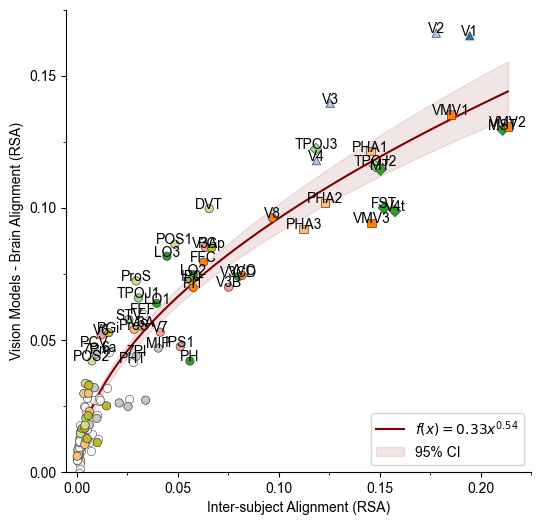

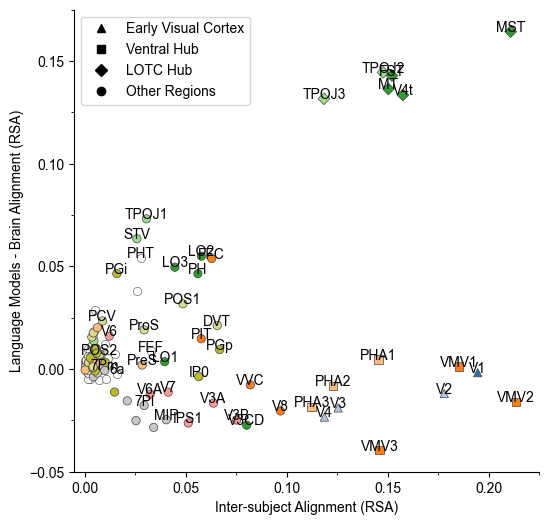

In [11]:
# Load all the files and aggregate the data
df_comparison = proccess_alignment(
    models_filename=models_filename,
    models_alignment_filename=model_brain_joined_filename,
    subject_alignment_filename=intersubject_shift1_joined_filename,
    pvalues_filename=pvalues_filename,
    hcp_filename=hcp_filename,
    group_subject=True,
)


n_boot = 10000
df_intersubject = pd.read_parquet(intersubject_shift1_joined_filename)
top_areas = process_intersubject_rois(
    df_intersubject, hcp_filename=hcp_filename, top=10
).area.unique()
palette = (
    df_comparison[["area", "area_color"]]
    .drop_duplicates()
    .set_index("area")
    .to_dict()["area_color"]
)
data = df_comparison.query("intersubject_p_value < 0.05").copy()
data = add_cluster(data)
data["top_area"] = data["area"].apply(lambda x: x in top_areas)


fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6))  # Vision models
fig2, ax2 = plt.subplots(1, 1, figsize=(6, 6))  # Language models


# Vision models
plot_comparison(data=data, x="intersubject_rsa", y="vision_rsa", ax=ax1, palette=palette)

x_fit, y_fit, y_lower, y_upper, r2, params = fit_powerlaw_zero_with_bootstrap(
    data["intersubject_rsa"], data["vision_rsa"], n_boot=n_boot
)
print(f"Vision Models - Brain Pseudo-R²: {r2:.3f} N Boostrap samples: {n_boot}")
print(f"Power-law parameters: y={params[0]:.3f}x^{params[1]:.3f}")

ax1.plot(
    x_fit, y_fit, color="maroon", label=f"$f(x)={params[0]:.2f}x^{{{params[1]:.2f}}}$", zorder=-10
)
ax1.fill_between(x_fit, y_lower, y_upper, color="maroon", alpha=0.1, label="95% CI", zorder=-20)
ax1.legend(loc="lower right")


# Language models
plot_comparison(data=data, x="intersubject_rsa", y="language_rsa", ax=ax2, palette=palette)


for i, row in data.iterrows():
    if row["vision_rsa"] > 0.04 or row["intersubject_rsa"] > 0.04 or row["language_rsa"] > 0.04:
        ax1.text(
            row["intersubject_rsa"],
            row["vision_rsa"],
            row["name"],
            ha="center",
        )
        ax2.text(row["intersubject_rsa"], row["language_rsa"], row["name"], ha="center")

# Add labels, legend and some plot adjustments
ax1.set_xlabel("Inter-subject Alignment (RSA)")
ax1.set_ylabel("Vision Models - Brain Alignment (RSA)")
ax2.set_xlabel("Inter-subject Alignment (RSA)")
ax2.set_ylabel("Language Models - Brain Alignment (RSA)")
triangle = mlines.Line2D(
    [], [], color="black", marker="^", linestyle="None", label="Early Visual Cortex"
)
square = mlines.Line2D([], [], color="black", marker="s", linestyle="None", label="Ventral Hub")
diamond = mlines.Line2D([], [], color="black", marker="D", linestyle="None", label="LOTC Hub")
circle = mlines.Line2D([], [], color="black", marker="o", linestyle="None", label="Other Regions")
legend_handles = [triangle, square, diamond, circle]
ax2.legend(handles=legend_handles, title="")
ax1.set_ylim(0, 0.175)
ax2.set_ylim(-0.05, 0.175)
ax1.set_xlim(-0.005, 0.225)
ax2.set_xlim(-0.005, 0.225)

# Add a major tick every 0.05, a minor tick every 0.025
for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.025))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.025))

# Save as svg to manually edit the text labels to avoid overlapping
fig1.savefig(output / "07_rsa_models_vision_comparison.svg", bbox_inches="tight", transparent=True)
fig2.savefig(
    output / "07_rsa_models_language_comparison.svg", bbox_inches="tight", transparent=True
)

## 5. Hub‑Based Modality Comparison  
Group alignments by predefined hubs (Visual Cortex, Ventral Hub, Dorsal Hub), plot boxplots comparing modalities (Inter‑subject, Vision, Language), conduct paired t‑tests with Bonferroni correction, and annotate significant differences.

,cluster,comparison,t_stat,p_value,mean_diff,p_corrected,apa_star
0,Visual Cortex,vision_rsa vs language_rsa,19.039129,2.744085e-07,0.161150,8.232255e-07,***
1,Ventral Cluster,vision_rsa vs language_rsa,19.994274,1.958745e-07,0.125294,5.876235e-07,***
2,Dorsal Cluster,vision_rsa vs language_rsa,-8.678705,5.400182e-05,-0.028736,1.620054e-04,***


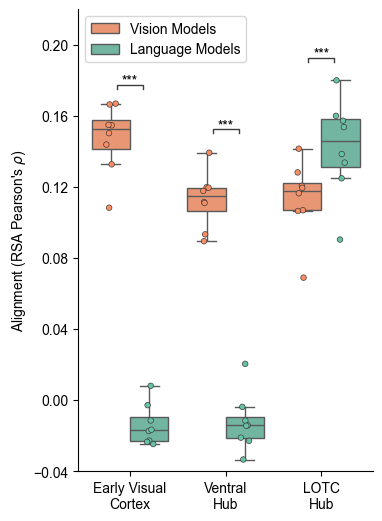

In [12]:
df_comparison_subjects = proccess_alignment(
    models_filename=models_filename,
    models_alignment_filename=model_brain_joined_filename,
    subject_alignment_filename=intersubject_shift1_joined_filename,
    pvalues_filename=pvalues_filename,
    hcp_filename=hcp_filename,
    group_subject=False,
)

df_comparison_subjects = add_cluster(df_comparison_subjects)
df_comparison_subjects_grouped = (
    df_comparison_subjects.groupby(["subject", "cluster"])
    .aggregate({"intersubject_rsa": "mean", "vision_rsa": "mean", "language_rsa": "mean"})
    .reset_index()
)
df_comparison_subjects_test = df_comparison_subjects_grouped.query("cluster != 'Other'").copy()

# Boxplot
fig, ax = plt.subplots(1, 1, figsize=(3.8, 6))


order = ["Visual\nCortex", "Ventral\nHub", "Dorsal\nHub"]
df_comparison_subjects_grouped.cluster = df_comparison_subjects_grouped.cluster.str.replace(
    " ", "\n"
).str.replace("Cluster", "Hub")
hue_names = {
    "intersubject_rsa": "Inter-subject",
    "vision_rsa": "Vision Models",
    "language_rsa": "Language Models",
}
# hue_order = ["Inter-subject", "Vision Models", "Language Models"]
hue_order = ["Vision Models", "Language Models"]
# hue_order = ["Vision", "Language"]
df_comparison_subjects_grouped = df_comparison_subjects_grouped.rename(columns=hue_names)
df_comparison_subjects_grouped = df_comparison_subjects_grouped.melt(
    id_vars=["subject", "cluster"], var_name="modality", value_name="score"
).copy()
df_comparison_subjects_grouped
from cmap import Colormap

cm = Colormap("colorbrewer:Set2_3").to_matplotlib()([0.5, 0, 1])
cm = list(list(c) for c in cm)[:2]
sns.boxplot(
    data=df_comparison_subjects_grouped,
    x="cluster",
    y="score",
    hue="modality",
    ax=ax,
    order=order,
    hue_order=hue_order,
    palette=cm,
    showfliers=False,  # width=0.5,
)
# Plot individual points with jitter
sns.stripplot(
    data=df_comparison_subjects_grouped,
    x="cluster",
    y="score",
    hue="modality",
    ax=ax,
    order=order,
    hue_order=hue_order,
    palette=cm,
    dodge=True,
    alpha=1,
    linewidth=0.5,
    size=4,
    jitter=True,
    edgecolor=(0.24, 0.24, 0.24),
    zorder=100,
    legend=False,
)

ax.set_xlabel("")
ax.set_ylabel(r"Alignment (RSA Pearson's $\rho$)")
# Remove title from legend
ax.legend(title="", loc="upper left")  # , bbox_to_anchor=(0, 0.3))

# xticks from each 0.05
ax.set_yticks(np.arange(-0.04, 0.21, 0.04))

sns.despine(ax=ax)

# Define dataframe
df_comparison_subjects_test

# Define comparisons explicitly
comparisons = [
    ("Visual Cortex", "vision_rsa", "language_rsa"),
    ("Ventral Cluster", "vision_rsa", "language_rsa"),
    ("Dorsal Cluster", "vision_rsa", "language_rsa"),
    # ("Dorsal Cluster", "language_rsa", "intersubject_rsa"),
    # ("Visual Cortex", "vision_rsa", "intersubject_rsa"),
]

results = []
for cluster, cond1, cond2 in comparisons:
    subset = df_comparison_subjects_test.query("cluster == @cluster")
    t_stat, p_value = ttest_rel(subset[cond1], subset[cond2])

    results.append(
        {
            "cluster": cluster,
            "comparison": f"{cond1} vs {cond2}",
            "t_stat": t_stat,
            "p_value": p_value,
            "mean_diff": subset[cond1].mean() - subset[cond2].mean(),
        }
    )

# Convert to dataframe
results_df = pd.DataFrame(results)

# Correct p-values (FDR correction)
results_df["p_corrected"] = multipletests(results_df["p_value"], method="bonferroni")[
    1
]  # .round(5)
results_df["apa_star"] = results_df["p_corrected"].apply(
    lambda x: "***" if x < 0.001 else ("**" if x < 0.01 else ("*" if x < 0.05 else "n.s."))
)


# Show results
display(results_df)
ax.set_ylim(-0.040, 0.22)
width = 0.135
add_pvalue_bracket(ax=ax, x1=-width, x2=width, y=0.175, height=0.0025, text="***")
add_pvalue_bracket(ax=ax, x1=1 - width, x2=1 + width, y=0.15, height=0.0025, text="***")
add_pvalue_bracket(ax=ax, x1=2 - width, x2=2 + width, y=0.19, height=0.0025, text="***")

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["Early Visual\nCortex", "Ventral\nHub", "LOTC\nHub"])

fig.savefig(
    output / "08_rsa_modality_boxplot_comparison.pdf", bbox_inches="tight", transparent=True
)